In [18]:
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)
import numpy as np
import scipy
import hist

import sys
sys.path.append("../../..")

import torch

%load_ext autoreload
%autoreload 1
from hists.parameters import synchrotronBeamEnergiesMap, beamEnergies
from hists.custom_hists import beamEnergiesAxis
from ntupleReaders.clue_ntuple_reader import ClueNtupleReader
%aimport ml.regression.drn.modules
from ml.regression.drn.modules import DRNDataset, ratioTransform, DRNDataModule, tracksterEnergyTransform, RatioCorrectedLoss
from ml.regression.drn.dataset_making import LayerClustersTensorMaker

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
def tracksterCorrectedEstimate(rawTracksterEnergy):
    """ Correction function of trackster energy 
    Returns corrected trackster energy
    """
    a = [-0.2597882 , -0.24326517,  1.01537901] # for simulation
    return rawTracksterEnergy * 1/ (a[0] * rawTracksterEnergy**(a[1]) + a[2] )

In [12]:
reader = ClueNtupleReader("v40", "cmssw", "sim_proton_v46_patchMIP")
dataset = DRNDataset(reader, datasetComputationClass=LayerClustersTensorMaker, pre_transform=ratioTransform)
datamodule = DRNDataModule(reader, LayerClustersTensorMaker, tracksterEnergyTransform)
datamodule.prepare_data()
datamodule.setup("fit")

In [21]:
loss = RatioCorrectedLoss([-0.2597882 , -0.24326517,  1.01537901], reduction="none")
h = hist.Hist(beamEnergiesAxis(), storage=hist.storage.Weight)
for batch in datamodule.train_dataloader():
    losses = loss(torch.ones_like(batch.beamEnergy), batch)
    h.fill(batch.beamEnergy, weight=losses)
    single_batch = batch
    

/grid_mnt/vol_home/llr/cms/cuisset/mambaforge/envs/clustering-analysis-gpu2/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)
/grid_mnt/vol_home/llr/cms/cuisset/mambaforge/envs/clustering-analysis-gpu2/lib/python3.10/site-packages/torch_geometric/data/collate.py:145: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  storage = elem.storage()._new_shared(numel)


In [22]:
h

Hist(IntCategory([20, 30, 50, 80, 100, 120, 150, 200, 250, 300], name='beamEnergy', label='Beam energy (GeV)'), storage=Weight()) # Sum: WeightedSum(value=1.76013e+06, variance=7.77347e+08)

In [24]:
h.view().value

array([ 34138.82617956,      0.        , 107298.11311136, 142813.29001178,
            0.        , 194633.38293148, 254814.9103512 , 329231.13863341,
            0.        , 697200.30600647])

In [16]:
single_batch.beamEnergy

tensor([ 80.,  80., 150.,  ...,  50.,  20., 200.])

In [6]:
losses = defaultdict(list)
for data in dataset:
    tracksterEnergy = torch.sum(data.x[:, 3]).item()
    tracksterEnergyCorr = tracksterCorrectedEstimate(tracksterEnergy)
    r_hat = 1
    loss = (r_hat * tracksterEnergyCorr - data.trueBeamEnergy.item())**2
    losses[data.beamEnergy.item()].append(loss)

In [10]:
losses =  dict(sorted(losses.items()))
class_corrected_losses = {beamEnergy : np.array(losses_list)/len(losses_list) for beamEnergy, losses_list in losses.items()}

<BarContainer object of 7 artists>

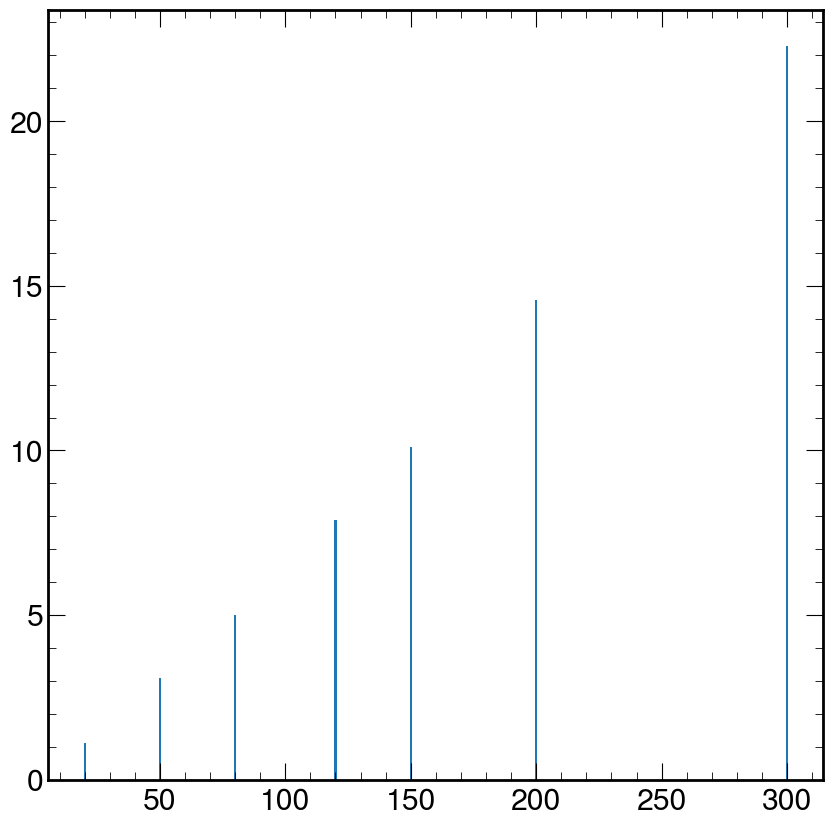

In [11]:
plt.bar(list(class_corrected_losses.keys()), [sum(losses) for losses in class_corrected_losses.values()])

In [16]:
import torch_geometric.loader
batch = next(iter(torch_geometric.loader.DataLoader(dataset, batch_size=2)))

In [23]:
RatioCorrectedLoss

tensor([ 0.2203,  1.1610,  2.5184,  4.3519,  0.1707,  6.9958,  8.8507,  0.0671,
        11.0141, 10.0720, 10.8473,  9.1773,  7.5854,  8.2291,  7.6893,  4.1672,
         5.2147,  3.1361,  3.2306,  1.6776,  1.7982,  0.0436,  1.0041,  1.3259,
         0.7549,  0.0848,  0.4544,  0.0554,  0.0361,  0.0767,  0.1221,  0.1476,
         0.0977,  0.0295,  0.0321,  0.0497,  0.6173,  1.7092,  5.3793,  6.4365,
        11.3475, 10.8499, 12.1795, 10.9045, 10.7231,  9.6410,  8.5726,  6.8716,
         4.9564,  3.4566,  3.0501,  1.8395,  1.3047,  0.7432,  0.0520,  0.7760,
         0.0484,  0.0773,  0.2842,  0.0727,  0.4278,  0.1144,  0.0860,  0.1038,
         0.0291,  0.1926,  0.0564,  0.1095])